In [3]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import os
import geopandas as gpd
import rioxarray
import hvplot.xarray 
import pandas as pd
import numpy as np

In [4]:
# # !mkdir -p /inputs/CHIRPS
# !wget "https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/1981/chirps-v3.0.rnl.1981.01.01.tif"

In [5]:
path_shapefiles = Path('../MSWEP/shapefiles')

In [6]:
basins_mapping = {
    'paso_mazangano': 'CAMELS_UY_10',
    'picada_de_coelho': 'CAMELS_UY_7',
    'sarandi_del_yi': 'CAMELS_UY_12',
    'paso_de_las_toscas': 'CAMELS_UY_8',
    'paso_de_las_piedras_rn': 'CAMELS_UY_15',
    'paso_del_borracho': 'CAMELS_UY_6',
    'bequelo': 'CAMELS_UY_16',
    'paso_de_las_piedras': 'CAMELS_UY_2',
    'paso_baltasar': 'CAMELS_UY_5',
    'fraile_muerto': 'CAMELS_UY_11',
    'paso_de_los_mellizos': 'CAMELS_UY_14',
    'paso_manuel_diaz': 'CAMELS_UY_3',
    'paso_aguiar': 'CAMELS_UY_9',
    'paso_de_la_compania': 'CAMELS_UY_1',
    'tacuarembo': 'CAMELS_UY_4',
    'durazno': 'CAMELS_UY_13'
}

In [7]:
shapefiles = os.listdir(path_shapefiles)
shapefiles=shapefiles[1:]
shapefiles

['paso_de_las_piedras.zip',
 'paso_de_la_compania.zip',
 'fraile_muerto.zip',
 'paso_aguiar.zip',
 'mercedes.zip',
 'bequelo.zip',
 'sarandi_del_yi.zip',
 'paso_manuel_diaz.zip',
 'paso_de_los_mellizos.zip',
 'paso_de_las_toscas.zip',
 'paso_del_borracho.zip',
 'picada_de_coelho.zip',
 'paso_mazangano.zip',
 'paso_de_las_piedras_rn.zip',
 'paso_baltasar.zip',
 'tacuarembo.zip']

In [8]:
ds = xr.open_dataset("chirps-v3.0.rnl.1981.01.01.tif")
# ds
precip = ds["band_data"].isel(band=0)
precip

<xarray.DataArray 'band_data' (y: 2400, x: 7200)> Size: 69MB
[17280000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 58kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * y            (y) float64 19kB 59.97 59.92 59.87 ... -59.88 -59.93 -59.98
    spatial_ref  int64 8B ...
Attributes:
    TIFFTAG_DOCUMENTNAME:      /home/CHIRPS/v3.0/daily/ERA5/1981/chirps-v3.0....
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_SOFTWARE:          IDL 8.9.0, L3Harris Geospatial Solutions, Inc.
    TIFFTAG_DATETIME:          2025:01:07 14:33:54
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    AREA_OR_POINT:             Area

In [9]:
precip = precip.where(precip != -9999, np.nan)

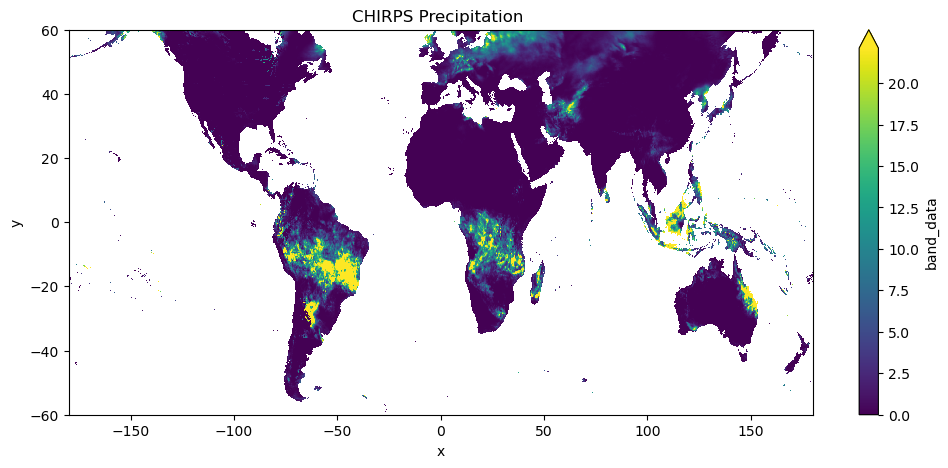

In [10]:
# Plot
fig, ax = plt.subplots(figsize=(12,5))
precip.plot(
    ax=ax,
    x="x",
    y="y",
    cmap="viridis",
    # vmin=0, vmax=30,
    robust=True  # avoids extreme outliers messing up colors
)

# Use the filename or date from attributes since there is no time coordinate
ax.set_title(f"CHIRPS Precipitation {ds.attrs.get('TIFFTAG_DOCUMENTNAME','')}")
plt.show()

In [11]:
path_shapefiles = Path('../MSWEP/shapefiles')
shp_file = path_shapefiles / 'paso_de_las_piedras.zip'  # example

# Load with geopandas
gdf = gpd.read_file(shp_file)

In [12]:
gdf.bounds

,minx,miny,maxx,maxy
0,-55.722917,-31.532917,-55.237083,-30.832917


In [13]:
# Give the DataArray a CRS
precip.rio.write_crs("EPSG:4326", inplace=True)

# Tell rioxarray which dims are spatial
precip_sel = precip.rio.set_spatial_dims(x_dim="x", y_dim="y")

# Merge geometry (in case shapefile has multiple polygons)
geometry = gdf.union_all() #.buffer(0.25)

# Clip
precip_clipped = precip_sel.rio.clip([geometry], precip_sel.rio.crs, drop=True)

In [14]:
precip_clipped

<xarray.DataArray 'band_data' (y: 14, x: 9)> Size: 504B
array([[       nan, 0.04357613, 0.03344828,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.05028624, 0.03767406, 0.02718309,        nan,
               nan,        nan,        nan,        nan],
       [       nan,        nan, 0.04503664, 0.03091513, 0.03758715,
               nan,        nan,        nan,        nan],
       [       nan,        nan, 0.06432585, 0.04588369, 0.0438131 ,
        0.03547841, 0.02815104,        nan,        nan],
       [       nan,        nan, 0.07415942, 0.05600252, 0.057094  ,
        0.04773876, 0.03633984,        nan,        nan],
       [       nan,        nan, 0.09042525, 0.06966163, 0.06916583,
        0.05682861, 0.04780522,        nan,        nan],
       [       nan, 0.12742259, 0.10116816, 0.07850314, 0.08376561,
        0.07221057, 0.05258809, 0.04147536, 0.03104672],
       [       nan, 0.13884906, 0.10885446, 0.08454878, 0.0914885 ,
        0.07947697, 0.0648524 , 0.05220474, 0.03788598],
       [       nan, 0.24202229, 0.1925359 , 0.14983378, 0.14017636,
        0.11619867, 0.09351968, 0.0748303 , 0.05446374],
       [0.26729032, 0.2274987 , 0.18273745, 0.14139374, 0.12591822,
        0.10521178, 0.08474182, 0.06796946,        nan],
       [0.22612236, 0.19257149, 0.15379196, 0.11237802, 0.10666886,
        0.08607551, 0.07206904,        nan,        nan],
       [0.1969399 , 0.1643366 , 0.13271536, 0.10430705, 0.09736308,
        0.0824743 ,        nan,        nan,        nan],
       [       nan, 0.15115683, 0.12462413, 0.10133766, 0.10079237,
               nan,        nan,        nan,        nan],
       [       nan,        nan, 0.132998  ,        nan,        nan,
               nan,        nan,        nan,        nan]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 72B -55.67 -55.62 -55.57 ... -55.37 -55.32 -55.27
  * y            (y) float64 112B -30.88 -30.93 -30.98 ... -31.43 -31.48 -31.53
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      /home/CHIRPS/v3.0/daily/ERA5/1981/chirps-v3.0....
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_SOFTWARE:          IDL 8.9.0, L3Harris Geospatial Solutions, Inc.
    TIFFTAG_DATETIME:          2025:01:07 14:33:54
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    AREA_OR_POINT:             Area

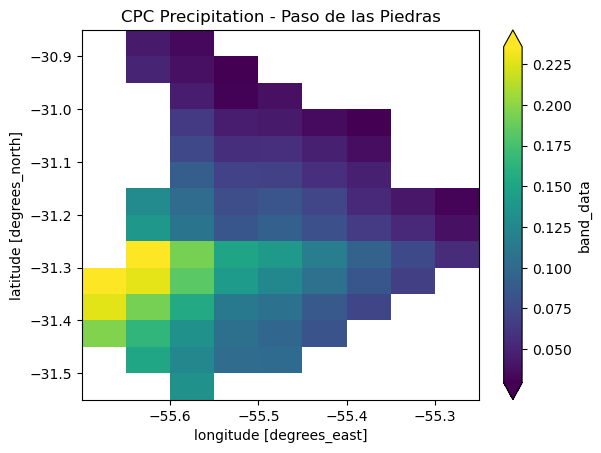

In [15]:
precip_clipped.plot(cmap="viridis", robust=True)
plt.title(f"CPC Precipitation - Paso de las Piedras")
plt.show()

# Creating the timeseries

In [1]:
# import os
# from datetime import datetime, timedelta

# # Folder to save the files
# out_dir = "/inputs/CHIRPS_v3"
# os.makedirs(out_dir, exist_ok=True)

# # Date range
# start_date = datetime(1989, 1, 1)
# end_date = datetime(2019, 12, 31)
# delta = timedelta(days=1)

# base_url = "https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/{year}/chirps-v3.0.rnl.{year}.{month:02d}.{day:02d}.tif"

# current_date = start_date
# while current_date <= end_date:
#     year = current_date.year
#     month = current_date.month
#     day = current_date.day

#     url = base_url.format(year=year, month=month, day=day)
#     out_file = os.path.join(out_dir, f"chirps-v3.0.rnl.{year}.{month:02d}.{day:02d}.tif")

#     # Use wget in Jupyter/Colab style
#     if not os.path.exists(out_file):
#         !wget -q -O {out_file} {url}
#         print(f"Downloaded: {out_file}")
#     else:
#         print(f"Already exists: {out_file}")

#     current_date += delta


In [16]:
# exclude_basins = [
#     'mercedes',
#     'paso_de_las_piedras',
#     'paso_de_la_compania',
#     'fraile_muerto',
#     'durazno',
#     'paso_aguiar'
# ]

In [18]:
import xarray as xr
import geopandas as gpd
import regionmask
import pandas as pd
from pathlib import Path
import os

# shapefiles folder
path_shapefiles = Path('../MSWEP/shapefiles')

# CHIRPS folder
chirps_folder = Path('/inputs/CHIRPS_v3/')

# Output directory
output_dir = Path('./precip_timeseries')
output_dir.mkdir(exist_ok=True)

# Mapping shapefile names to CAMELS_UY IDs
basins_mapping = {
    'paso_mazangano': 'CAMELS_UY_10',
    'picada_de_coelho': 'CAMELS_UY_7',
    'sarandi_del_yi': 'CAMELS_UY_12',
    'paso_de_las_toscas': 'CAMELS_UY_8',
    'paso_de_las_piedras_rn': 'CAMELS_UY_15',
    'paso_del_borracho': 'CAMELS_UY_6',
    'bequelo': 'CAMELS_UY_16',
    'paso_de_las_piedras': 'CAMELS_UY_2',
    'paso_baltasar': 'CAMELS_UY_5',
    'fraile_muerto': 'CAMELS_UY_11',
    'paso_de_los_mellizos': 'CAMELS_UY_14',
    'paso_manuel_diaz': 'CAMELS_UY_3',
    'paso_aguiar': 'CAMELS_UY_9',
    'paso_de_la_compania': 'CAMELS_UY_1',
    'tacuarembo': 'CAMELS_UY_4',
    'durazno': 'CAMELS_UY_13'
}

# List all shapefiles
shapefiles = [f for f in os.listdir(path_shapefiles) if f.endswith('.zip')]

# list daily files
chirps_files = sorted(chirps_folder.glob("*.tif"))

# Iterate over all shapefiles
for shp_file in shapefiles:
    basin_name = shp_file.replace('.zip', '')

    # # Skip excluded basins
    # if basin_name in exclude_basins:
    #     print(f"Skipping {basin_name}")
    #     continue

    camels_id = basins_mapping[basin_name]

    print(f"Processing {basin_name} -> {camels_id}")

    gdf = gpd.read_file(path_shapefiles / shp_file).to_crs("EPSG:4326")
    geom = gdf.union_all()

    # create mask using first file
    ds0 = xr.open_dataset(chirps_files[0])
    pr0 = ds0["band_data"].isel(band=0)
    
    minx, miny, maxx, maxy = geom.bounds
    pr0 = pr0.sel(x=slice(minx-0.2, maxx+0.2),
                  y=slice(maxy+0.2, miny-0.2))  # y usually descending
    mask = regionmask.mask_geopandas(gdf, pr0.x, pr0.y)
    ds0.close()

    all_ts = []

    # loop over years
    for file in chirps_files:

        # extract date from filename
        date_str = file.stem.split('.')[-3:]
        date = pd.to_datetime('-'.join(date_str))
        
        print(f"Processing {basin_name} - {date.date()}")

        ds = xr.open_dataset(file)
        precip = ds["band_data"].isel(band=0)

        # replace nodata
        precip = precip.where(precip != -9999, np.nan)

        # subset bbox
        precip = precip.sel(x=slice(minx-0.2, maxx+0.2),
                            y=slice(maxy+0.2, miny-0.2))

        # apply mask
        precip_basin = precip.where(mask == 0)

        # spatial average
        value = precip_basin.mean(dim=("y", "x")).item()

        # extract date from filename
        date_str = file.stem.split('.')[-3:]
        date = pd.to_datetime('-'.join(date_str))

        all_ts.append((date, value))

        ds.close()

    # build dataframe
    full_ts = pd.Series(
        data=[v for _, v in all_ts],
        index=[d for d, _ in all_ts],
        name="precipitation"
    ).sort_index()

    # save
    output_file = output_dir / f"{camels_id}_precip.csv"
    full_ts.to_csv(output_file)

    print(f"Saved {output_file}")


Processing durazno -> CAMELS_UY_13
Processing durazno - 1989-01-01
Processing durazno - 1989-01-02
Processing durazno - 1989-01-03
Processing durazno - 1989-01-04
Processing durazno - 1989-01-05
Processing durazno - 1989-01-06
Processing durazno - 1989-01-07
Processing durazno - 1989-01-08
Processing durazno - 1989-01-09
Processing durazno - 1989-01-10
Processing durazno - 1989-01-11
Processing durazno - 1989-01-12
Processing durazno - 1989-01-13
Processing durazno - 1989-01-14
Processing durazno - 1989-01-15
Processing durazno - 1989-01-16
Processing durazno - 1989-01-17
Processing durazno - 1989-01-18
Processing durazno - 1989-01-19
Processing durazno - 1989-01-20
Processing durazno - 1989-01-21
Processing durazno - 1989-01-22
Processing durazno - 1989-01-23
Processing durazno - 1989-01-24
Processing durazno - 1989-01-25
Processing durazno - 1989-01-26
Processing durazno - 1989-01-27
Processing durazno - 1989-01-28
Processing durazno - 1989-01-29
Processing durazno - 1989-01-30
Proce

KeyboardInterrupt: 